In [1]:
# This branch of qiskit is required:  pip install git+https://github.com/LNoorl/qiskit-terra.git@feature/sk-pass

import numpy as np
import dreamcoder as dc
from dreamcoder.domains.quantum_circuits.primitives import *
from dreamcoder.domains.quantum_circuits.tasks import *
import dill as pickle
import time
from tqdm import trange, tqdm
import random
import bin.binutil
import datetime
import glob
import os
%load_ext line_profiler
%load_ext autoreload
%autoreload 2


In [2]:
import rsmf  # Right size my figures for paper

fmt = rsmf.setup("quantum_template.tex")

### Begin analysis

Choose target experiment output

In [3]:
# [Full connectivity experiments]
# folder = "experimentOutputs/quantum/2023-03-22T01:42:59.384211" # 3 qubits 2023 <-- best
folder = "experimentOutputs/quantum/2023-03-28T19:15:45.929940"  # 3 qubits 2023   <-- analyze this

# [Limited connectivity experiments]
# folder = "experimentOutputs/quantum/2023-04-03T09:19:58.138238" # <-- analyze this
# folder = "experimentOutputs/quantum/2023-04-08T11:01:59.834537" # structurePenalty=3  << best run, but many more primitives


# [Grammar generalization experiments]
# from grammar test: 2023-04-19T11:24:16.939668
# 5 qubits 300s test: 2023-04-19T11:36:42.695517
# 5 qubits shorter test: 2023-04-19T15:40:36.472743
# 5 qubits shorter test from grammar: 2023-04-19T18:39:48.080905
# folder = "experimentOutputs/quantum/2023-04-19T18:39:48.080905"


name = {}
simplification = {}
depth = {}

folder_plots = f"{folder}/plots"
if not os.path.exists(folder_plots):
    os.mkdir(folder_plots)

folder_primitives = f"{folder}/primitives"
if not os.path.exists(folder_primitives):
    os.mkdir(folder_primitives)

In [4]:
# The following are auxiliary functions to handle invented primitives


def get_primitive_arguments(tp, arguments, last_qubit=0):
    # Get argument to run a primitive
    if len(tp.arguments) != 0:
        if tp.arguments[0].name == "int":
            arguments.append(last_qubit)
            last_qubit += 1
        elif tp.arguments[0].name == "tcircuit":
            arguments.append(["no_op"])
        return get_primitive_arguments(tp.arguments[1], arguments, last_qubit)

    else:
        for i in range(len(arguments)):
            if type(arguments[i]) == list:
                arguments[i] = no_op(last_qubit)
        return arguments


def randomize_arguments(arguments):
    idx_to_randomize = []
    for idx, element in enumerate(arguments):
        if isinstance(element, (int, np.int32, np.int64)):
            idx_to_randomize.append(idx)
    numbers = np.random.choice(
        np.arange(len(idx_to_randomize)), size=len(idx_to_randomize)
    )
    for idx, n in zip(idx_to_randomize, numbers):
        arguments[idx] = n
    return arguments


def lb(s, T=20):
    s = s.split()
    l = []
    n = 0
    for w in s:
        if n + len(w) > T:
            l.append("<br />")
            n = 0
        n += len(w)
        l.append(w)
    return " ".join(l)


def get_program_children(program):
    try:
        return {k: getName(k) for _, k in program.body.walk() if k.isInvented}
    except:
        return {k: getName(k) for _, k in program.walk() if k.isInvented}


def get_program_simplification(program):
    if program in name:
        return name[program]
    children = get_program_children(program)
    simplification_ = program
    for k, childName in children.items():
        simplification_ = simplification_.substitute(
            k, dc.program.Primitive(childName, ty=None, value=None)
        )
    return simplification_


def getName(program):
    if program in name:
        return name[program]
    children = get_program_children(program)
    simplification_ = get_program_simplification(program.body)
    # for original, simplified in nameSimplification.items():
    #     simplification_ = simplification_.substitute(Primitive(original,None,None),
    #                                                     Primitive(simplified,None,None))
    name[program] = "f%d" % len(name)
    # name[program] = f"f{len(name):03d}" # need to make name unambigous (f1 and f13 is not nice for easy string replacement)

    simplification[program] = simplification_
    depth[program] = 1 + max([depth[k] for k in children] + [0])
    return name[program]


def get_primitive_lambda(n_qubit, operation_name):
    if n_qubit == 1:
        return lambda old_circuit, q: n_qubit_gate(
            old_circuit, q, operation_name=operation_name
        )
    elif n_qubit == 2:
        return lambda old_circuit, q1, q2: n_qubit_gate(
            old_circuit, q1, q2, operation_name=operation_name
        )
    elif n_qubit == 3:
        return lambda old_circuit, q1, q2, q3: n_qubit_gate(
            old_circuit, q1, q2, q3, operation_name=operation_name
        )
    elif n_qubit == 4:
        return lambda old_circuit, q1, q2, q3, q4: n_qubit_gate(
            old_circuit, q1, q2, q3, q4, operation_name=operation_name
        )
    elif n_qubit == 5:
        return lambda old_circuit, q1, q2, q3, q4, q5: n_qubit_gate(
            old_circuit, q1, q2, q3, q4, q5, operation_name=operation_name
        )
    elif n_qubit == 6:
        return lambda old_circuit, q1, q2, q3, q4, q5, q6: n_qubit_gate(
            old_circuit, q1, q2, q3, q4, q5, q6, operation_name=operation_name
        )
    elif n_qubit == 7:
        raise Exception("ask Kevin.")


def get_qk_lambda(n_qubit, gate):
    if n_qubit == 1:
        return lambda QT, q1: QT.circuit.append(gate, (QT.q(q1),))
    elif n_qubit == 2:
        return lambda QT, q1, q2: QT.circuit.append(gate, (QT.q(q1), QT.q(q2)))
    elif n_qubit == 3:
        return lambda QT, q1, q2, q3: QT.circuit.append(
            gate, (QT.q(q1), QT.q(q2), QT.q(q3))
        )
    elif n_qubit == 4:
        return lambda QT, q1, q2, q3, q4: QT.circuit.append(
            gate, (QT.q(q1), QT.q(q2), QT.q(q3), QT.q(q4))
        )
    elif n_qubit == 5:
        return lambda QT, q1, q2, q3, q4, q5: QT.circuit.append(
            gate, (QT.q(q1), QT.q(q2), QT.q(q3), QT.q(q4), QT.q(q5))
        )
    elif n_qubit == 6:
        return lambda QT, q1, q2, q3, q4, q5, q6: QT.circuit.append(
            gate, (QT.q(q1), QT.q(q2), QT.q(q3), QT.q(q4), QT.q(q5), QT.q(q6))
        )
    elif n_qubit == 7:
        raise Exception("ask Kevin.")


def f_circuit(circuit_unitary, *qubit, circuit_template):
    # eprint(circuit_template)
    n_args, circuit_ops = circuit_template
    circuit_ops = list(circuit_ops)
    # apply template
    # returns a tuple of circuit ops ( ("gate", 1, 2, ...), ...   )
    circuit_ops = (((op[0], *[qubit[q] for q in op[1:]])) for op in circuit_ops)

    for op in circuit_ops:
        circuit_unitary = full_op_names[op[0]](circuit_unitary, *op[1:])
    return circuit_unitary


def print_simplified_grammar(grammar):
    returned_dictionary = dict()

    def productionKey(primitive):
        (l, t, p) = primitive  # likelihood, type, program_object
        return l is not None and -l

    if grammar.continuationType is not None:
        lines = ["continuation : %s" % grammar.continuationType]
    else:
        lines = []

    lines += ["%f\tt0\t$_" % grammar.logVariable]
    for l, t, p in sorted(grammar.productions, key=productionKey):
        if isinstance(p, dc.program.Invented):
            p_string = "f" + str(
                get_program_simplification(dc.program.Program.parse(str(p)))[1:]
            )
            p_simplified = list(simplification.values())[int(p_string[1:])]
            p_name = f"{p_string}:{p_simplified}"
        else:
            p_string = str(p)
            p_simplified = str(p)
            p_name = str(p)

        if l is not None:
            line = f"{l}\t{p_name: <75}\t{t}"
        else:
            line = "-Inf\t{p_name: <75}\t{t}"
        if not t.isArrow() and isinstance(p, dc.program.Invented):
            try:
                line += "\teval = {p.evaluate([])}"
            except BaseException:
                pass
        returned_dictionary[p_string] = [l, t, p_simplified]
        lines.append(line)
    return "\n".join(lines), returned_dictionary

Load data files

In [5]:
files = glob.glob(f"{folder}/quantum_train_dumped_results_*")
files.sort(key=lambda x: int(x.split("_")[-2]))
max_iteration = int(files[-1].split("_")[-2])
# max_iteration = 97

with open(f"{folder}/arguments.pickle", "rb") as f:
    experiment_arguments = pickle.load(f)

dc.domains.quantum_circuits.primitives.GLOBAL_NQUBIT_TASK = n_qubit_tasks = int(
    experiment_arguments["nqubit"]
)
dc.domains.quantum_circuits.primitives.GLOBAL_LIMITED_CONNECTIVITY = (
    experiment_arguments["limitedConnectivity"]
)
print("Limited connectivity:", experiment_arguments["limitedConnectivity"])

with open(f"{folder}/quantum_train_dumped_results_{max_iteration}_", "rb") as f:
    results = pickle.load(f)

with open(f"{folder}/quantum_test_{max_iteration}_dumped_results_0_", "rb") as f:
    results_test = pickle.load(f)

print(f"Loaded {max_iteration} iterations.")

Limited connectivity: False
Loaded 99 iterations.


In [7]:
with open(f"{folder}/quantum_test-train_{max_iteration}_dumped_results_0_", "rb") as f:
    results_validation = pickle.load(f)

with open(f"{folder}/solved_train.txt", "r") as f:
    f_frontiers_validation = f.readlines()
validation_frontiers = [int(t) for t in f_frontiers_validation]

In [6]:
# This would just be a consistency check: can we enumerate the same grammar we generated?
with open(f"{folder}/quantum_full_dumped_results_0_", "rb") as f:
    results_full = pickle.load(f)

print(
    f"It was able to reconstruct {results_full.learningCurve[-1]}/{len(results_full.frontiersOverTime)} tasks"
)
if results_full.learningCurve[-1] != len(results_full.frontiersOverTime):
    for idx, (task, frontier) in enumerate(results_full.frontiersOverTime.items()):
        if len(frontier[-1].entries) == 0:
            print("TASK UNSOLVED!")
            true_circuit = get_qiskit_circuit((n_qubit_tasks, task.target_circuit))
            print(f"---------------------------------------")
            print(f"Task {task.name}")
            print("True")
            print(true_circuit.circuit)
            break

    raise (
        Exception(
            "Since it was not able to enumerate all full tasks with the full set of gates, there must be a bug in the code checking if a circuits gives the requested unitary. This is not good."
        )
    )

for idx, (task, frontier) in enumerate(results_full.frontiersOverTime.items()):
    if abs(task.target_circuit_evaluation.max()) > 3:
        print("This is not good, really. Not good.")
        print("There must be a bug in the comparison of unitary matrices up to a phase")

It was able to reconstruct 49688/49688 tasks


Check performance: how many tasks have been solved?

In [7]:
max(results_validation.trainSearchTime.values())


186.10590648651123

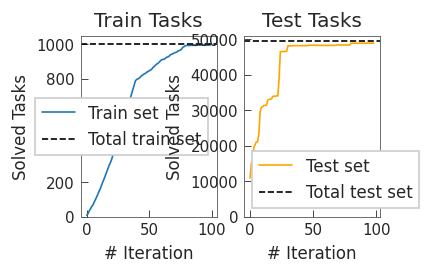

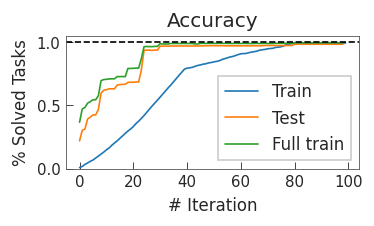

Train set:	995/1000 (99.50%)
Test set:	48941/49688 (98.50%)
Validation set:	997/1000 (99.70%)


In [8]:
# Test results do not have a learning curve (since we always start from scratch).
# This is the slow way to load the test results.
# Since it is slow, we also save the values during the experiments.
# test_frontiers = []
# for i in trange(max_iteration):
#     with open(f"{folder}/quantum_test_{i+1}_dumped_results_0_","rb") as f:
#         r_test = pickle.load(f)
#     test_frontiers.append(r_test.learningCurve[0])

with open(f"{folder}/solved_test.txt", "r") as f:
    f_frontiers = f.readlines()

test_frontiers = [int(t) for t in f_frontiers]

%matplotlib inline
# plt.figure(figsize=[5,5], dpi=75)
fmt.figure()
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(results.learningCurve)), results.learningCurve, label="Train set")
plt.axhline(len(results.frontiersOverTime), linestyle="--", c="black", label="Total train set")
plt.title("Train Tasks")
plt.xlabel("# Iteration")
plt.ylabel("Solved Tasks")
plt.ylim([0, None])
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(np.arange(len(test_frontiers)), test_frontiers, c="orange", label="Test set")
plt.axhline(len(results_test.frontiersOverTime), linestyle="--", c="black", label="Total test set")
# plt.axhline(results_test.learningCurve[-1],linestyle="--",c="orange", label="Total test set")
plt.legend()
plt.title("Test Tasks")
plt.xlabel("# Iteration")
plt.ylabel("Solved Tasks")
plt.ylim([0, None])
plt.show()

# Same plots, but overlapped
%matplotlib inline
# plt.figure(figsize=[5,5], dpi=130)
fmt.figure()
# plt.plot(np.arange(len(results.learningCurve)),np.array(results.learningCurve)/len(results.frontiersOverTime), label=f"Train ({len(results.frontiersOverTime)} tasks)")
# plt.plot(np.arange(len(test_frontiers)),np.array(test_frontiers)/len(results_test.frontiersOverTime),c="orange", label=f"Test ({len(results_test.frontiersOverTime)} tasks)")
# plt.plot(np.arange(len(validation_frontiers)),np.array(validation_frontiers)/len(results_validation.frontiersOverTime),c="green", label=f"Validation ({len(results_validation.frontiersOverTime)} tasks)")
plt.plot(np.arange(len(results.learningCurve)), np.array(results.learningCurve)/len(results.frontiersOverTime), label=f"Train", color="C0")
plt.plot(np.arange(len(test_frontiers)), np.array(test_frontiers)/len(results_test.frontiersOverTime), label=f"Test",  color="C1")
plt.plot(np.arange(len(validation_frontiers)), np.array(validation_frontiers)/len(results_validation.frontiersOverTime), label=f"Full train", color="C2")
plt.axhline(1, linestyle="--", c="black")
plt.xlabel("# Iteration")
plt.ylabel("% Solved Tasks")
plt.ylim([0, None])
plt.legend()
plt.title("Accuracy")
plt.tight_layout()
plt.savefig("experimentOutputs/fig3a.pdf")
plt.show()

print(f"Train set:\t{np.array(results.learningCurve)[-1]}/{len(results.frontiersOverTime)} ({(np.array(results.learningCurve)[-1]/len(results.frontiersOverTime))*100:2.2f}%)")
print(f"Test set:\t{np.array(test_frontiers)[-1]}/{len(results_test.frontiersOverTime)} ({(np.array(test_frontiers)[-1]/len(results_test.frontiersOverTime))*100:2.2f}%)")
print(f"Validation set:\t{np.array(validation_frontiers)[-1]}/{len(results_validation.frontiersOverTime)} ({(np.array(validation_frontiers)[-1]/len(results_validation.frontiersOverTime))*100:2.2f}%)")


Get extracted primitives.
Add extracted primitives to GLOBAL primitives

In [11]:
invented_primitives = [p for p in results.grammars[-1].primitives if p.isInvented]

for p in invented_primitives:
    getName(p)

depths = {depth[p] for p in invented_primitives}
depth2primitives = {
    d: {p for p in invented_primitives if depth[p] == d} for d in depths
}

# needed to print primitives with right file name (when limited connectivity)
limited_primitives_idx = {}

# Define primitive circuit operations as globals
for i, (original, simplified) in enumerate(simplification.items()):
    arguments = get_primitive_arguments(original.tp, [])
    n_qubit = len(arguments) - 1
    limited_primitives_idx[original] = i

    dc.program.Primitive.GLOBALS[name[original]] = dc.program.Primitive(
        name=name[original],
        ty=original.tp,
        value=dc.utilities.Curried(get_primitive_lambda(n_qubit, name[original])),
    )
    program = dc.program.Program.parse(str(original))
    dc.domains.quantum_circuits.primitives.GLOBAL_LIMITED_CONNECTIVITY = False

    # while 1:
    #     try:
    circuit = execute_program(program, arguments)
    #     break
    # except QuantumCircuitException:
    #     arguments =  randomize_arguments(arguments)
    #     print("Invalid circuit -> Randomizing arguments: ", arguments)

    dc.domains.quantum_circuits.primitives.full_op_names[
        name[original]
    ] = lambda tensor, *qubit, circuit_template=circuit: f_circuit(
        tensor, *qubit, circuit_template=circuit_template
    )

    simplified_program = dc.program.Program.parse(str(simplified))

    # TODO: problem with limited connectivity
    if experiment_arguments["limitedConnectivity"]:
        print(
            "Note that the simplified version can only have wrong arguments sometimes! Bug in the execution with constrained connectivity!"
        )
    simplified_circuit = execute_program(
        simplified_program, get_primitive_arguments(original.tp, [])
    )
    dc.domains.quantum_circuits.primitives.GLOBAL_LIMITED_CONNECTIVITY = (
        experiment_arguments["limitedConnectivity"]
    )

    qk_circuit = get_qiskit_circuit(simplified_circuit).circuit
    qk_circuit.name = name[original]
    dc.domains.quantum_circuits.primitives.qiskit_full_op_names[
        name[original]
    ] = get_qk_lambda(n_qubit, qk_circuit.to_gate())

    eta_long = dc.program.EtaLongVisitor().execute(simplified_program)
    print(f"{name[original]}: {eta_long}")  # EtaLong for a better program string
    # print(original)
    print("Simplified circuit")
    print(qk_circuit)
    qk_circuit.draw(output="mpl", filename=f"{folder_primitives}/{i}.pdf")
    print("Expanded circuit")
    print(get_qiskit_circuit(circuit).circuit)
    get_qiskit_circuit(circuit).circuit.draw(
        output="mpl", filename=f"{folder_primitives}/r{i}.pdf"
    )
    print("-------------------------------------------")

f0: (lambda (lambda (t (t $0 $1) $1)))
Simplified circuit
   ┌───┐┌───┐
q: ┤ T ├┤ T ├
   └───┘└───┘
Expanded circuit
   ┌───┐┌───┐
q: ┤ T ├┤ T ├
   └───┘└───┘
-------------------------------------------
f1: (lambda (lambda (tdg (tdg $0 $1) $1)))
Simplified circuit
   ┌─────┐┌─────┐
q: ┤ Tdg ├┤ Tdg ├
   └─────┘└─────┘
Expanded circuit
   ┌─────┐┌─────┐
q: ┤ Tdg ├┤ Tdg ├
   └─────┘└─────┘
-------------------------------------------
f2: (lambda (lambda (lambda (f0 $0 (cnot $1 $2 $0)))))
Simplified circuit
     ┌───┐┌────┐
q_0: ┤ X ├┤ f0 ├
     └─┬─┘└────┘
q_1: ──■────────
                
Expanded circuit
     ┌───┐┌───┐┌───┐
q_0: ┤ X ├┤ T ├┤ T ├
     └─┬─┘└───┘└───┘
q_1: ──■────────────
                    
-------------------------------------------
f3: (lambda (lambda (f0 $0 (h $1 $0))))
Simplified circuit
   ┌───┐┌────┐
q: ┤ H ├┤ f0 ├
   └───┘└────┘
Expanded circuit
   ┌───┐┌───┐┌───┐
q: ┤ H ├┤ T ├┤ T ├
   └───┘└───┘└───┘
-------------------------------------------
f4: (lambda (lambda

In [12]:
# dc.domains.quantum_circuits.primitives.GLOBAL_LIMITED_CONNECTIVITY = True
if dc.domains.quantum_circuits.primitives.GLOBAL_LIMITED_CONNECTIVITY:
    limited_primitives = {p for p in results.grammars[-1].primitives if p.isInvented}
    for progr in limited_primitives:
        print(f"Primitive #{idx}")
        arguments = get_primitive_arguments(progr.tp, [])

        while 1:
            try:
                program = execute_program(progr, arguments)
                break
            except QuantumCircuitException:
                arguments = randomize_arguments(arguments)
                print("Invalid circuit -> Randomizing arguments: ", arguments)

        print_circuit(program)
        primitive_name = limited_primitives_idx[progr]
        print_circuit(
            program, filename=f"{folder_primitives}/limited_{primitive_name}.pdf"
        )
        # WARNING! The ID does not correspond to the real primitive name
    len(primitives)

Plot extracted primitives during time 

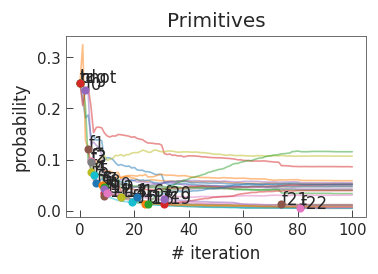

In [13]:
primitive_likelihood = {}

for idx_grammar, grammar in enumerate(results.grammars):
    for production in grammar.productions:
        p = production[-1]
        if isinstance(p, dc.program.Invented):
            p_string = str(
                get_program_simplification(dc.program.Program.parse(str(p)))[1:]
            )
            p_name = f"f{p_string}"
        else:
            p_name = p

        if p_name not in primitive_likelihood:
            primitive_likelihood[p_name] = []
        primitive_likelihood[p_name].append([idx_grammar, np.exp(production[0])])


# Normalize the production probability
normalization_weights = {i: 0.0 for i in range(max_iteration + 2)}
for primitive in primitive_likelihood.values():
    for idx, likelihood in primitive:
        normalization_weights[idx] += likelihood

for primitive in primitive_likelihood.values():
    for i in range(len(primitive)):
        primitive[i][1] /= normalization_weights[primitive[i][0]]


# plt.figure(dpi=300,figsize=[3,1.5])
fmt.figure()
plt.title("Primitives")
for primitive, likelihoods in primitive_likelihood.items():
    l_array = np.array(likelihoods)
    # likelihood contains (time, value)
    plt.plot(l_array[:, 0], l_array[:, 1], label=primitive, alpha=0.5)
    plt.scatter(*l_array[0], s=15, zorder=10)
    plt.annotate(primitive, l_array[0])
plt.xlabel("# iteration")
plt.ylabel("probability")
plt.savefig(f"{folder_plots}/primitive_evolution.pdf")
plt.show()

In [14]:
primitive, l_array[0]


('f22', array([8.10000000e+01, 5.34244723e-03]))

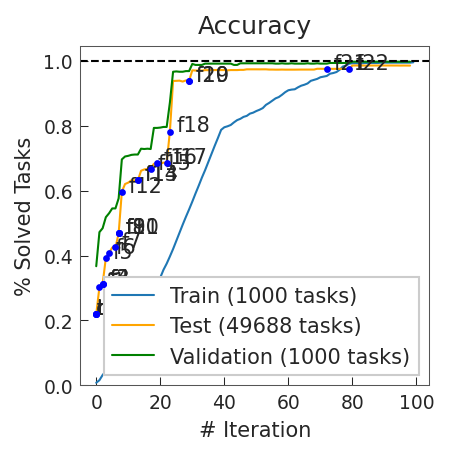

In [15]:
# Same plots, but overlapped
%matplotlib inline
plt.figure(figsize=[3, 3], dpi=150)
plt.plot(np.arange(len(results.learningCurve)), np.array(results.learningCurve)/len(results.frontiersOverTime), label=f"Train ({len(results.frontiersOverTime)} tasks)")
plt.plot(np.arange(len(test_frontiers)), np.array(test_frontiers)/len(results_test.frontiersOverTime), c="orange", label=f"Test ({len(results_test.frontiersOverTime)} tasks)")
plt.plot(np.arange(len(validation_frontiers)), np.array(validation_frontiers)/len(results_validation.frontiersOverTime),
         c="green", label=f"Validation ({len(results_validation.frontiersOverTime)} tasks)")
plt.axhline(1, linestyle="--", c="black")
plt.xlabel("# Iteration")
plt.ylabel("% Solved Tasks")
plt.ylim([0, None])
plt.legend()
plt.title("Accuracy")

for primitive, likelihoods in primitive_likelihood.items():
    l_array = np.array(likelihoods)
    y_location = (np.array(test_frontiers)/len(results_test.frontiersOverTime))[int(np.clip(l_array[0][0]-2, 0, None))]
    plt.scatter(np.clip(l_array[0][0]-2, 0, None), y_location, s=5, color="blue", zorder=10)
    plt.annotate(primitive, (l_array[0][0], y_location))

plt.show()


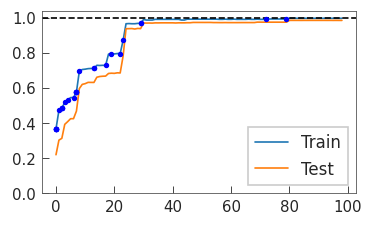

In [16]:
# Same plots, but overlapped
%matplotlib inline
# plt.figure(figsize=[3.2,3], dpi=150)
fmt.figure()
# plt.plot(np.arange(len(results.learningCurve)),np.array(results.learningCurve)/len(results.frontiersOverTime), c="C2", label=f"Train")
plt.plot(np.arange(len(validation_frontiers)), np.array(validation_frontiers)/len(results_validation.frontiersOverTime), c="C0", label=f"Train")
plt.plot(np.arange(len(test_frontiers)), np.array(test_frontiers)/len(results_test.frontiersOverTime), c="C1", label=f"Test")
plt.axhline(1, linestyle="--", c="black")
# plt.xlabel("# Iteration")
# plt.ylabel("% Solved Tasks")
plt.ylim([0, None])
plt.legend()
# plt.title("Accuracy")
plt.tight_layout()
for primitive, likelihoods in primitive_likelihood.items():
    l_array = np.array(likelihoods)
    y_location = (np.array(validation_frontiers)/len(results_validation.frontiersOverTime))[int(np.clip(l_array[0][0]-2, 0, None))]
    plt.scatter(np.clip(l_array[0][0]-2, 0, None), y_location, s=5, color="blue", zorder=10)
plt.savefig(f"{folder_plots}/training_plot.pdf")
plt.show()


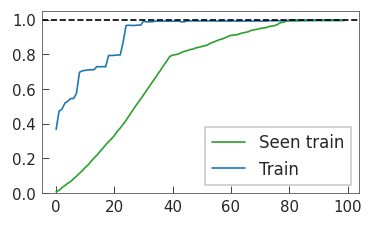

In [17]:
# Same plots, but overlapped
%matplotlib inline
# plt.figure(figsize=[3.2,3], dpi=150)
fmt.figure()
plt.plot(np.arange(len(results.learningCurve)), np.array(results.learningCurve)/len(results.frontiersOverTime), c="C2", label=f"Seen train")
plt.plot(np.arange(len(validation_frontiers)), np.array(validation_frontiers)/len(results_validation.frontiersOverTime), c="C0", label=f"Train")
# plt.plot(np.arange(len(test_frontiers)),np.array(test_frontiers)/len(results_test.frontiersOverTime),c="C1", label=f"Test")
plt.axhline(1, linestyle="--", c="black")
# plt.xlabel("# Iteration")
# plt.ylabel("% Solved Tasks")
plt.ylim([0, None])
plt.legend()
# plt.title("Accuracy")
plt.tight_layout()
# for primitive, likelihoods in primitive_likelihood.items():
#     l_array = np.array(likelihoods)
#     y_location = (np.array(validation_frontiers)/len(results_validation.frontiersOverTime))[int(np.clip(l_array[0][0]-2,0,None))]
#     plt.scatter(np.clip(l_array[0][0]-2,0,None),y_location, s=5, color="blue", zorder=10)
plt.savefig(f"{folder_plots}/appendix_training_plot.pdf")
plt.show()


Count solved/unsolved

In [18]:
n_solved = 0
r = results_test
for idx, (task, frontier) in tqdm(enumerate(r.frontiersOverTime.items())):
    f = frontier[-1]
    if len(f.entries) > 0:
        n_solved += 1

print(
    f"Solved {n_solved}/{len(r.taskSolutions)} tasks. ({n_solved/len(r.taskSolutions)*100:2.2f}%)"
)

49688it [00:00, 647980.03it/s]

Solved 48945/49688 tasks. (98.50%)


Analyze solved and unsolved tasks

In [19]:
solved_tasks = []
r = results_validation
for idx, (task, frontier) in enumerate(r.frontiersOverTime.items()):
    if idx > 800:
        f = frontier[-1]
        true_circuit = get_qiskit_circuit((n_qubit_tasks, task.target_circuit))
        print(f"---------------------------------------")
        print(f"Task {task.name}")
        print("True")
        print(true_circuit.circuit)

        if len(f.entries) > 0:
            solved = f.entries[0]
            program = solved.program
            simplified_program = get_program_simplification(program)
            # reparse to update primitive functions
            simplified_program = dc.program.Program.parse(str(simplified_program))
            # arguments = task.examples[0][0] weird bug! ask Kevin
            arguments = (*range(n_qubit_tasks), (n_qubit_tasks, ()))
            circuit = execute_program(simplified_program, arguments)

            # print(f"originally proposed circuit: {program}")
            print(f"reconstructed_circuit: {simplified_program}")
            reconstructed_circuit = get_qiskit_circuit(circuit)
            print(reconstructed_circuit.circuit)

            c_depth = len(execute_program(program, arguments)[1])
            solved_tasks.append([task, circuit, c_depth])

        else:
            print("TASK UNSOLVED!")
            # break
print(
    f"Solved {len(solved_tasks)}/{len(r.taskSolutions)} tasks. ({len(solved_tasks)/len(r.taskSolutions)*100:2.2f}%)"
)

---------------------------------------
Task t_1649_(lambda (lambda (lambda (lambda (cy (cnot $0 $1 $2) $3 $2)))))
True
               
q_0: ──■───────
     ┌─┴─┐┌───┐
q_1: ┤ X ├┤ Y ├
     └───┘└─┬─┘
q_2: ───────■──
               
reconstructed_circuit: (lambda (lambda (lambda (lambda (f4 (cnot $0 $1 $2) $2 $3)))))
                 
q_0: ──■─────────
     ┌─┴─┐┌─────┐
q_1: ┤ X ├┤0    ├
     └───┘│  f4 │
q_2: ─────┤1    ├
          └─────┘
---------------------------------------
Task t_1648_(lambda (lambda (lambda (lambda (cy (cnot $0 $1 $2) $3 $1)))))
True
          ┌───┐
q_0: ──■──┤ Y ├
     ┌─┴─┐└─┬─┘
q_1: ┤ X ├──┼──
     └───┘  │  
q_2: ───────■──
               
reconstructed_circuit: (lambda (lambda (lambda (lambda (f4 (cnot $0 $1 $2) $1 $3)))))
          ┌─────┐
q_0: ──■──┤0    ├
     ┌─┴─┐│     │
q_1: ┤ X ├┤  f4 ├
     └───┘│     │
q_2: ─────┤1    ├
          └─────┘
---------------------------------------
Task t_22127_(lambda (lambda (lambda (lambda (ch (h (tdg $0 $3) $3) $3 $

Task likelihood

Estimating likelihood of solving tasks at the beginning

In [20]:
def get_S(q_1):
    return (("t", q_1), ("t", q_1))


def get_SX(q_1):
    return (("hadamard", q_1), ("t", q_1), ("t", q_1), ("hadamard", q_1))


def get_SXDG(q_1):
    return (("hadamard", q_1), ("tdg", q_1), ("tdg", q_1), ("hadamard", q_1))


def get_X(q_1):
    return (
        ("hadamard", q_1),
        ("t", q_1),
        ("t", q_1),
        ("t", q_1),
        ("t", q_1),
        ("hadamard", q_1),
    )


def get_Y(q_1):
    return (
        ("hadamard", q_1),
        ("t", q_1),
        ("t", q_1),
        ("hadamard", q_1),
        ("tdg", q_1),
        ("tdg", q_1),
        ("hadamard", q_1),
        ("t", q_1),
        ("t", q_1),
    )


def get_Z(q_1):
    return (("t", q_1), ("t", q_1), ("t", q_1), ("t", q_1))


def get_CY(q_2, q_1):
    return (("tdg", q_1), ("tdg", q_1), ("cnot", q_2, q_1), ("t", q_1), ("t", q_1))


def get_CZ(q_1, q_2):
    return (("hadamard", q_1), ("cnot", q_2, q_1), ("hadamard", q_1))


def get_CH(q_2, q_1):
    return (
        ("t", q_1),
        ("t", q_1),
        ("hadamard", q_1),
        ("t", q_1),
        ("cnot", q_2, q_1),
        ("tdg", q_1),
        ("hadamard", q_1),
        ("tdg", q_1),
        ("tdg", q_1),
    )


def get_CS(q_1, q_2):
    return (
        ("t", q_1),
        ("cnot", q_1, q_2),
        ("tdg", q_2),
        ("cnot", q_1, q_2),
        ("t", q_2),
    )


def get_SWAP(q_1, q_2):
    return (("cnot", q_2, q_1), ("cnot", q_1, q_2), ("cnot", q_2, q_1))


def get_iSWAP(q_1, q_2):
    return (
        ("t", q_1),
        ("t", q_1),
        ("t", q_2),
        ("t", q_2),
        ("hadamard", q_2),
        ("cnot", q_2, q_1),
        ("cnot", q_1, q_2),
        ("hadamard", q_1),
    )


full_circuit_replacements_fn = {
    "x": get_X,
    "y": get_Y,
    "z": get_Z,
    "s": get_S,
    "sx": get_SX,
    "sxdg": get_SXDG,
    "cy": get_CY,
    "cz": get_CZ,
    "ch": get_CH,
    "cs": get_CS,
    "swap": get_SWAP,
    "iswap": get_iSWAP,
}


def get_full_circuit_decomposition(circuit_list):
    # Given a full circuit list (("swap",0,1), ...)
    # Return the elementary gate decomposition (("cnot",1,0), ...)
    target = []
    for gate in circuit_list:
        if gate[0] in full_circuit_replacements_fn:
            target += full_circuit_replacements_fn[gate[0]](*gate[1:])
        else:
            target.append(gate)
    return tuple(target)


# Generate programs from circuit lists:
def add_one_qubit_gate(initial_string, gate):
    gate_name = gate[0].replace("hadamard", "h")
    q_1 = n_qubit_tasks - gate[1]
    return initial_string.replace("$0", f"({gate_name} $0 ${q_1})")


def add_two_qubit_gate(initial_string, gate):
    gate_name = gate[0]
    q_1 = n_qubit_tasks - gate[1]
    q_2 = n_qubit_tasks - gate[2]
    return initial_string.replace("$0", f"({gate_name} $0 ${q_1} ${q_2})")


def circuit_list_to_program(circuit_list):
    new_circuit = "(lambda " * (n_qubit_tasks + 1) + "$0" + ")" * (n_qubit_tasks + 1)
    for gate in circuit_list[::-1]:
        if len(gate[1:]) == 1:
            new_circuit = add_one_qubit_gate(new_circuit, gate)
        elif len(gate[1:]) == 2:
            new_circuit = add_two_qubit_gate(new_circuit, gate)
    return new_circuit

In [21]:
r = results

# Also prepare information for initial and full task log likelihood
initial_loglikelihoods = []
train_loglikelihoods = []
full_loglikelihoods = []
for idx, (task, frontier) in enumerate(r.frontiersOverTime.items()):
    f = frontier[-1]
    if len(f.entries) > 0:
        solution = f.entries[0].program

        # Initial likelihood: we build it by disassembling the solution
        # (real enumeration would take too much time)
        decomposed = get_full_circuit_decomposition(task.target_circuit)
        new_program = dc.program.Program.parse(circuit_list_to_program(decomposed))
        # Consistency check:
        # if task.logLikelihood(new_program) != task.logLikelihood(solution):
        #     print(task.name)
        #     raise Exception("There is a bug in the substitution function.")
        initial_loglikelihoods.append(
            results.grammars[0].logLikelihood(new_program.infer(), new_program)
        )

        entries = sorted(f.entries, key=lambda x: x.logPrior)
        program = entries[-1].program
        train_loglikelihoods.append(
            results.grammars[-1].logLikelihood(program.infer(), program)
        )

        full_program = dc.program.Program.parse(task.name.split("_")[2])
        full_loglikelihoods.append(
            full_grammar.logLikelihood(full_program.infer(), full_program)
        )
print("All is good! Consistency check passed.")

All is good! Consistency check passed.


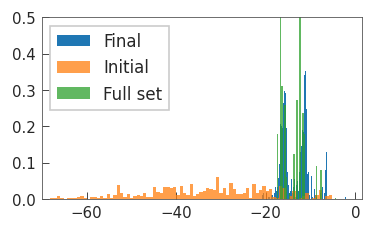

In [22]:
# plt.figure(dpi=150, figsize=[5,4])
# plt.rcParams.update({'font.size': 17})
# plt.title("Final task solution loglikelihood distribution")
fmt.figure(width_ratio=1)
plt.hist(train_loglikelihoods, 100, density=True, color="C0", label="Final")
plt.hist(
    initial_loglikelihoods, 100, density=True, color="C1", label="Initial", alpha=0.75
)
plt.hist(
    full_loglikelihoods, 40, density=True, color="C2", label="Full set", alpha=0.75
)
# plt.xlabel("Log likelihood")
# plt.ylabel("Prob")
plt.legend()
plt.tight_layout()
plt.xlim([-70, None])
plt.ylim([0, 0.5])
plt.savefig(f"{folder_plots}/final_probability.pdf")
plt.show()

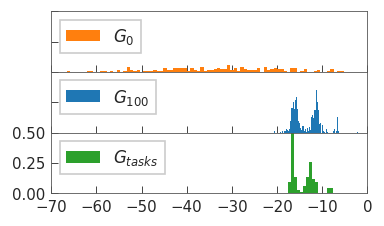

In [24]:
# plt.figure(dpi=150, figsize=[5,4])
# plt.rcParams.update({'font.size': 17})
# plt.title("Final task solution loglikelihood distribution")
fig = fmt.figure(width_ratio=1)
ax = [plt.subplot(3, 1, i + 1) for i in range(3)]
ax[0].hist(initial_loglikelihoods, 100, density=True, color="C1", label=r"$G_0 $")
ax[1].hist(train_loglikelihoods, 100, density=True, color="C0", label=r"$G_{100}$")
ax[2].hist(full_loglikelihoods, 20, density=True, color="C2", label=r"$G_{tasks}$")

for a in ax:
    if a != ax[-1]:
        a.set_xticklabels([])
        a.set_yticklabels([])
    a.set_xlim([-70, 0])
    a.set_ylim([0, 0.5])
    a.legend(loc="upper left")
# plt.xlabel("Log likelihood")
# plt.ylabel("Prob")
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig(f"{folder_plots}/final_probability.pdf")
plt.show()

Plot primitive usage evolution

In [21]:
# WARNING! IT IS NOT REALLY A PROBABILITY,
# Some factor is missing!
def get_tasks_dict(results):
    tasks_dict = {}
    for task, frontiers in results.frontiersOverTime.items():
        for idx_f, f in enumerate(frontiers):
            if len(f.entries) > 0:
                grammar = results.grammars[idx_f]
                if task.name not in tasks_dict:
                    tasks_dict[task.name] = []
                # TODO: needs to sort f.entries according to logPrior
                entries = sorted(f.entries, key=lambda x: x.logPrior)
                program = entries[-1].program
                tasks_dict[task.name].append(
                    [
                        idx_f,  # iteration
                        grammar.logLikelihood(program.infer(), program),  # likelihood
                        #   f.entries[-1]] # program frontier
                    ]
                )
    return tasks_dict


tasks_dict = get_tasks_dict(results)
len(tasks_dict)

995

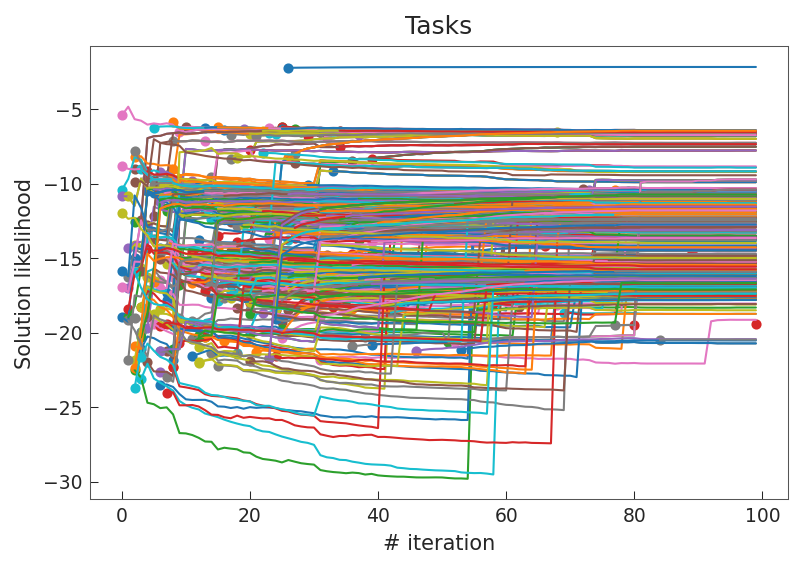

In [22]:
plt.figure(dpi=150)
for idx, (task, vals) in enumerate(tasks_dict.items()):
    vals_array = np.array(vals)
    plt.plot(*vals_array.T)
    plt.scatter(*vals_array[0], s=15)
    # plt.annotate(idx, vals_array[0])
plt.title("Tasks")
plt.xlabel("# iteration")
plt.ylabel("Solution likelihood")
# plt.semilogy()
plt.show()

Selecting only a few tasks for a better plot

In [23]:
random_idx = []
target_task_idx = set(
    [
        713,
        176,
        27,
        622,
        1641,
        235,
        43,
        1758,
        152,
        26266,
        1779,
        10,
        707,
        894,
        1813,
        23607,
    ]
)
# target_task_idx = set([43, 504 ,1614,23599,38, 18875, 24725, 1614, 40, 869, 9, 23599,23352, 1341, 1008,17])

# new set
# target_task_idx = set([1417, 43, 205,152, 422,974, 4397,29,478, 400, 44811])

# Plot for full connectivi
for j, tasks in enumerate(tasks_dict):
    idx = int(tasks.split("_")[1])
    if idx in target_task_idx:
        random_idx.append(j)

In [24]:
n_to_show = 0
random_tasks_idx = list(np.random.choice(len(tasks_dict), n_to_show))
print(random_tasks_idx)
random_tasks_idx += random_idx
random_tasks_list = [list(tasks_dict.items())[idx] for idx in random_tasks_idx]
[n[0] for n in random_tasks_list]

[]


['t_010_(lambda (lambda (lambda (lambda (s $0 $1)))))',
 't_043_(lambda (lambda (lambda (lambda (cs $0 $1 $2)))))',
 't_027_(lambda (lambda (lambda (lambda (sxdg $0 $3)))))',
 't_152_(lambda (lambda (lambda (lambda (t (s $0 $3) $2)))))',
 't_176_(lambda (lambda (lambda (lambda (t (z $0 $2) $2)))))',
 't_235_(lambda (lambda (lambda (lambda (tdg (z $0 $2) $3)))))',
 't_622_(lambda (lambda (lambda (lambda (tdg (cs $0 $1 $2) $1)))))',
 't_707_(lambda (lambda (lambda (lambda (s (cz $0 $1 $3) $2)))))',
 't_713_(lambda (lambda (lambda (lambda (s (cs $0 $1 $2) $2)))))',
 't_894_(lambda (lambda (lambda (lambda (y (cs $0 $1 $2) $3)))))',
 't_23607_(lambda (lambda (lambda (lambda (h (cz (cs $0 $1 $2) $1 $3) $1)))))',
 't_1641_(lambda (lambda (lambda (lambda (cnot (iswap $0 $2 $3) $2 $1)))))',
 't_26266_(lambda (lambda (lambda (lambda (tdg (cnot (cnot $0 $2 $1) $3 $1) $2)))))',
 't_1758_(lambda (lambda (lambda (lambda (cy (ch $0 $3 $1) $3 $2)))))',
 't_1779_(lambda (lambda (lambda (lambda (cy (isw

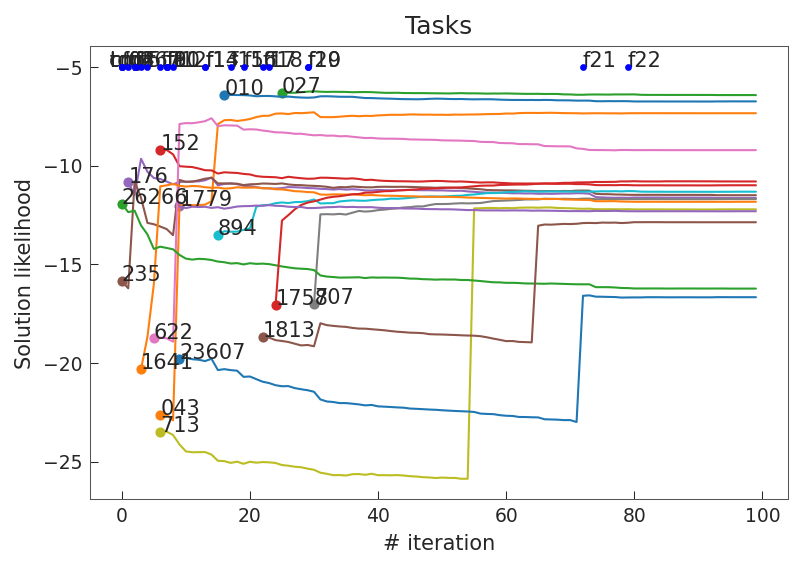

In [25]:
plt.figure(dpi=150)
for idx, (task, vals) in enumerate(random_tasks_list):
    vals_array = np.array(vals)
    plt.plot(*vals_array.T)
    plt.scatter(*vals_array[0], s=15)
    plt.annotate(task.split("_")[1], vals_array[0])
plt.title("Tasks")
plt.xlabel("# iteration")
plt.ylabel("Solution likelihood")
# plt.semilogy()

for primitive, likelihoods in primitive_likelihood.items():
    l_array = np.array(likelihoods)
    plt.scatter(np.clip(l_array[0][0] - 2, 0, None), -5, s=5, color="blue", zorder=10)
    plt.annotate(primitive, (l_array[0][0] - 2, -5))
plt.show()

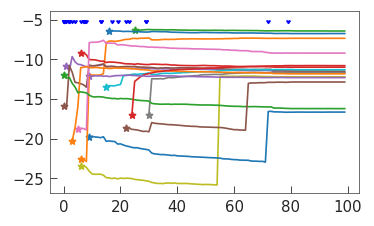

In [26]:
# plt.figure(dpi=150, figsize=[5,5])
fmt.figure()
for idx, (task, vals) in enumerate(random_tasks_list):
    vals_array = np.array(vals)
    plt.plot(*vals_array.T)
    plt.scatter(*vals_array[0], s=15, marker="*")
    # plt.annotate(task.split('_')[1], vals_array[0])
# plt.title("Tasks")
# plt.xlabel("# iteration")
# plt.ylabel("Solution likelihood")
# plt.semilogy()
plt.tight_layout()
for primitive, likelihoods in primitive_likelihood.items():
    l_array = np.array(likelihoods)
    plt.scatter(
        np.clip(l_array[0][0] - 2, 0, None), -5, s=5, color="blue", zorder=10, marker=11
    )
    # plt.annotate(primitive, (l_array[0][0]-2,-5))
# plt.xlim([None,65])
plt.savefig(f"{folder_plots}/task_likelihood_evolution.pdf")
plt.show()

Primitive usage histogram

In [28]:
primitive_counts = {}
r = results_test
unsolved = 0
for idx, (task, frontier) in enumerate(r.frontiersOverTime.items()):
    f = frontier[-1]

    if len(f.entries) > 0:
        solved = f.entries[0]
        program = solved.program
        simplified_program = get_program_simplification(program)
        # reparse to update primitive functions
        simplified_program = dc.program.Program.parse(str(simplified_program))
        # arguments = task.examples[0][0] weird bug! ask Kevin
        arguments = (*range(n_qubit_tasks), (n_qubit_tasks, ()))
        circuit = execute_program(simplified_program, arguments)

        for gate, *qubit in circuit[1]:
            gate = gate.replace("hadamard", "h")
            if gate not in primitive_counts:
                primitive_counts[gate] = 0
            primitive_counts[gate] += 1
    else:
        unsolved += 1
print("Unsolved tasks:", unsolved)

Unsolved tasks: 743


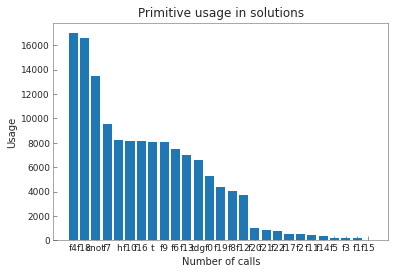

In [29]:
primitive_counts_list = list(primitive_counts.items())
primitive_counts_list.sort(key=lambda x: -x[1])
# plt.figure(dpi=100, figsize=[20,5])
plt.title("Primitive usage in solutions")
plt.xlabel("Number of calls")
plt.ylabel("Usage")
plt.bar(
    np.array(primitive_counts_list)[:, 0],
    np.array(primitive_counts_list)[:, 1].astype(int),
)
plt.show()

In [35]:
simplified_string, returned_dictionary = print_simplified_grammar(results.grammars[-1])
print(simplified_string)


-0.404657	t0	$_
-2.406605980492948	f18:(lambda (lambda (lambda (f17 $0 $1 (f7 $2 $0)))))                      	tcircuit -> int -> int -> tcircuit
-2.480767620498588	f4:(lambda (lambda (lambda (f2 $0 (f1 $1 $2) $1))))                        	tcircuit -> int -> int -> tcircuit
-2.700054692174592	cnot                                                                       	tcircuit -> int -> int -> tcircuit
-3.0816497424635294	f7:(lambda (lambda (f3 (f0 $0 $1) $0)))                                    	tcircuit -> int -> tcircuit
-3.1518822072068264	f10:(lambda (lambda (h (f3 $0 $1) $1)))                                    	int -> tcircuit -> tcircuit
-3.186092780221599	t                                                                          	tcircuit -> int -> tcircuit
-3.1994768974687267	f16:(lambda (lambda (f14 $0 $1 $0)))                                       	tcircuit -> int -> tcircuit
-3.212894778229293	f9:(lambda (lambda (h (f0 $0 (f3 $1 $0)) $0)))                             	tcir

In [26]:
latex_code = ""
for i in range(len(invented_primitives)):
    gate_program = str(returned_dictionary[f"f{i}"][-1]).replace("$", "\\$")
    latex_code += """
    {0}
    &\includegraphics[height=15mm,valign=m]{{figures/primitives-full/{1}.pdf}} 
    &\includegraphics[height=15mm,valign=m]{{figures/primitives-full/r{1}.pdf}} 
    &\\texttt{{{2}}}\\\\
    """.format(
        i, i, gate_program
    )
print(latex_code)

NameError: name 'returned_dictionary' is not defined

/tmp/ipykernel_28883/358553342.py:24: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.gca().set_xticks([])


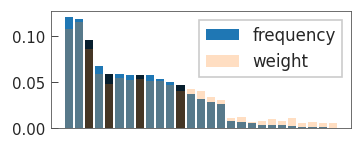

In [31]:
primitive_probability_list = []
normalization = sum(np.exp(primitive[0]) for primitive in returned_dictionary.values())
for primitive, values in returned_dictionary.items():
    primitive_probability_list.append([primitive, np.exp(values[0]) / normalization])

primitive_counts_list = list(primitive_counts.items())
primitive_counts_list.sort(key=lambda x: -x[1])
# plt.figure(dpi=250, figsize=[10,2])
fmt.figure(aspect_ratio=0.4)
plt.tight_layout()
# plt.title("Primitive usage in solutions")
# plt.xlabel("Gate")
# plt.ylabel("Usage")
normalized_counts = sum(np.array(primitive_counts_list)[:, 1].astype(int))
plt.bar(
    np.array(primitive_counts_list)[:, 0],
    np.array(primitive_counts_list)[:, 1].astype(int) / normalized_counts,
    label="frequency",
)

elementary_primitives_counts_list = [
    (name, val) for (name, val) in primitive_counts_list if name[0] != "f"
]
plt.bar(
    np.array(elementary_primitives_counts_list)[:, 0],
    np.array(elementary_primitives_counts_list)[:, 1].astype(int) / normalized_counts,
    color="black",
    alpha=0.75,
)

plt.bar(
    np.array(primitive_probability_list)[:, 0],
    np.array(primitive_probability_list)[:, 1].astype(float),
    alpha=0.25,
    label="weight",
)
plt.legend()
plt.gca().set_xticklabels([])
plt.gca().set_xticks([])
plt.savefig(f"{folder_plots}/primitive_usage.pdf")
plt.show()

In [32]:
smaller_primitive_likelihood = {
    k: p
    for k, p in primitive_likelihood.items()
    if str(k) in ["h", "t", "tdg", "cnot", "f18", "f4", "f7", "f10"]
}

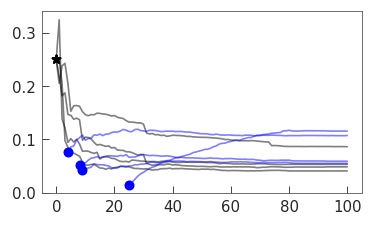

In [33]:
# plt.figure(dpi=250,figsize=[5.5,4])
# plt.rcParams.update({'font.size': 17})
# plt.title("Primitives")
fmt.figure(width_ratio=1)
for primitive, likelihoods in list(smaller_primitive_likelihood.items()):
    l_array = np.array(likelihoods)
    markerstyle = "o" if str(primitive)[0] == "f" else "*"
    color = "blue" if str(primitive)[0] == "f" else "black"
    plt.plot(l_array[:, 0], l_array[:, 1], label=primitive, alpha=0.5, color=color)
    plt.scatter(*l_array[0], s=25, zorder=10, marker=markerstyle, color=color)
    # plt.annotate(primitive, l_array[0])
# plt.xlabel("# iteration")
# plt.ylabel("probability")
plt.tight_layout()
plt.savefig(f"{folder_plots}/simpler_primitive_evolution.pdf")
plt.show()

Analyze a specific task (perhaps to show replacements)

In [34]:
r = results
for idx, (task, frontier) in enumerate(r.frontiersOverTime.items()):
    if "t_47067" in task.name:
        f = frontier[-1]
        true_circuit = get_qiskit_circuit((n_qubit_tasks, task.target_circuit))
        true_circuit.circuit.draw(
            output="mpl", filename=f"{folder_plots}/gate_example_target.pdf"
        )

        print(f"---------------------------------------")
        print(f"Task {task.name}")
        print("True")
        print(true_circuit.circuit)
        true_circuit.circuit.draw(
            output="mpl", filename=f"{folder_plots}/t{task.name.split('_')[1]}.pdf"
        )
        if len(f.entries) > 0:
            solved = f.entries[0]
            program = solved.program
            simplified_program = get_program_simplification(program)
            # reparse to update primitive functions
            simplified_program = dc.program.Program.parse(str(simplified_program))
            # arguments = task.examples[0][0] weird bug! ask Kevin
            arguments = (*range(n_qubit_tasks), (n_qubit_tasks, ()))
            circuit = execute_program(simplified_program, arguments)

            # print(f"originally proposed circuit: {program}")
            print(f"reconstructed_circuit: {simplified_program}")
            reconstructed_circuit = get_qiskit_circuit(circuit)
            reconstructed_circuit.circuit.draw(
                output="mpl",
                filename=f"{folder_plots}/t{task.name.split('_')[1]}_reconstructed.pdf",
            )

            # reconstructed_circuit.circuit.draw(output="mpl", filename=f"{folder_plots}/gate_example_compressed.pdf")
            print(reconstructed_circuit.circuit)

            print(f"reconstructed_circuit: {program}")
            full_circuit = execute_program(program, arguments)
            full_reconstructed_circuit = get_qiskit_circuit(full_circuit)
            print(full_reconstructed_circuit.circuit)
            full_reconstructed_circuit.circuit.draw(
                output="mpl", filename=f"{folder_plots}/gate_example_full.pdf"
            )
            c_depth = len(execute_program(program, arguments)[1])
        else:
            print("TASK UNSOLVED!")
        break

---------------------------------------
Task t_47067_(lambda (lambda (lambda (lambda (ch (s (cy $0 $1 $3) $1) $3 $1)))))
True
          ┌───┐┌───┐
q_0: ──■──┤ S ├┤ H ├
       │  └───┘└─┬─┘
q_1: ──┼─────────┼──
     ┌─┴─┐       │  
q_2: ┤ Y ├───────■──
     └───┘          
reconstructed_circuit: (lambda (lambda (lambda (lambda (f18 (f4 (f0 $1 $0) $3 $1) $3 $1)))))
     ┌────┐┌─────┐┌──────┐
q_0: ┤ f0 ├┤1    ├┤1     ├
     └────┘│     ││      │
q_1: ──────┤  f4 ├┤  f18 ├
           │     ││      │
q_2: ──────┤0    ├┤0     ├
           └─────┘└──────┘
reconstructed_circuit: (lambda (lambda (lambda (lambda (#(lambda (lambda (lambda (#(lambda (lambda (lambda (#(lambda (lambda (lambda (#(lambda (lambda (h (#(lambda (lambda (#(lambda (lambda (t (t $0 $1) $1))) $0 (h $1 $0)))) $0 $1) $1))) $0 (#(lambda (lambda (lambda (cnot (t (tdg (cnot $0 $1 $2) $2) $1) $1 $2)))) $1 $0 $2))))) (cnot $0 $1 $2) $1 $2)))) $0 $1 (#(lambda (lambda (#(lambda (lambda (#(lambda (lambda (t (t $0 $1) $1))) $0 (h $1 $0

In [23]:
task.name


't_50687_(lambda (lambda (lambda (lambda (iswap (iswap (sxdg $0 $3) $2 $3) $1 $3)))))'

In [25]:
appendix_tasks = sorted(
    [
        46832,
        48299,
        48987,
        45944,
        45980,
        47560,
        47750,
        1649,
        1747,
        1838,
    ]
)

for t in appendix_tasks:
    for idx, (task, frontier) in enumerate(results.frontiersOverTime.items()):
        if f"t_{t}_" in task.name:
            f = frontier[-1]
            true_circuit = get_qiskit_circuit((n_qubit_tasks, task.target_circuit))
            true_circuit.circuit.draw(
                output="mpl", filename=f"{folder_plots}/appendix_gate_{t}.pdf"
            )

            print(f"---------------------------------------")
            print(f"Task {task.name}")
            print("True")
            print(true_circuit.circuit)
            true_circuit.circuit.draw(
                output="mpl", filename=f"{folder_plots}/t{task.name.split('_')[1]}.pdf"
            )
            if len(f.entries) > 0:
                solved = f.entries[0]
                program = solved.program
                simplified_program = get_program_simplification(program)
                # reparse to update primitive functions
                simplified_program = dc.program.Program.parse(str(simplified_program))
                # arguments = task.examples[0][0] weird bug! ask Kevin
                arguments = (*range(n_qubit_tasks), (n_qubit_tasks, ()))
                circuit = execute_program(simplified_program, arguments)

                # print(f"originally proposed circuit: {program}")
                print(f"reconstructed_circuit: {simplified_program}")
                reconstructed_circuit = get_qiskit_circuit(circuit)
                reconstructed_circuit.circuit.draw(
                    output="mpl",
                    filename=f"{folder_plots}/appendix_gate_{t}_reconstructed.pdf",
                )

                # reconstructed_circuit.circuit.draw(output="mpl", filename=f"{folder_plots}/gate_example_compressed.pdf")
                print(reconstructed_circuit.circuit)

                print(f"reconstructed_circuit: {program}")
                full_circuit = execute_program(program, arguments)
                full_reconstructed_circuit = get_qiskit_circuit(full_circuit)
                print(full_reconstructed_circuit.circuit)
                full_reconstructed_circuit.circuit.draw(
                    output="mpl", filename=f"{folder_plots}/appendix_gate_{t}_full.pdf"
                )
                c_depth = len(execute_program(program, arguments)[1])
            else:
                print("TASK UNSOLVED!")
            break

---------------------------------------
Task t_1649_(lambda (lambda (lambda (lambda (cy (cnot $0 $1 $2) $3 $2)))))
True
               
q_0: ──■───────
     ┌─┴─┐┌───┐
q_1: ┤ X ├┤ Y ├
     └───┘└─┬─┘
q_2: ───────■──
               
reconstructed_circuit: (lambda (lambda (lambda (lambda (f4 (cnot $0 $1 $2) $2 $3)))))
                 
q_0: ──■─────────
     ┌─┴─┐┌─────┐
q_1: ┤ X ├┤0    ├
     └───┘│  f4 │
q_2: ─────┤1    ├
          └─────┘
reconstructed_circuit: (lambda (lambda (lambda (lambda (#(lambda (lambda (lambda (#(lambda (lambda (lambda (#(lambda (lambda (t (t $0 $1) $1))) $0 (cnot $1 $2 $0))))) $0 (#(lambda (lambda (tdg (tdg $0 $1) $1))) $1 $2) $1)))) (cnot $0 $1 $2) $2 $3)))))
                                       
q_0: ──■───────────────────────────────
     ┌─┴─┐┌─────┐┌─────┐┌───┐┌───┐┌───┐
q_1: ┤ X ├┤ Tdg ├┤ Tdg ├┤ X ├┤ T ├┤ T ├
     └───┘└─────┘└─────┘└─┬─┘└───┘└───┘
q_2: ─────────────────────■────────────
                                       
------------------------

In [33]:
latex_code = ""
for t in appendix_tasks:
    latex_code += """
    \includegraphics[height=15mm,valign=m]{{figures/appendix-tasks-full/appendix_gate_{0}.pdf}} 
    &\includegraphics[height=15mm,valign=m]{{figures/appendix-tasks-full/appendix_gate_{0}_reconstructed.pdf}} 
    &\includegraphics[height=15mm,valign=m]{{figures/appendix-tasks-full/appendix_gate_{0}_full.pdf}}\\\\
    """.format(
        t
    )
print(latex_code)


    \includegraphics[height=15mm,valign=m]{figures/appendix-tasks-full/appendix_gate_1649.pdf} 
    &\includegraphics[height=15mm,valign=m]{figures/appendix-tasks-full/appendix_gate_1649_reconstructed.pdf} 
    &\includegraphics[height=15mm,valign=m]{figures/appendix-tasks-full/appendix_gate_1649_full.pdf}\\
    
    \includegraphics[height=15mm,valign=m]{figures/appendix-tasks-full/appendix_gate_1747.pdf} 
    &\includegraphics[height=15mm,valign=m]{figures/appendix-tasks-full/appendix_gate_1747_reconstructed.pdf} 
    &\includegraphics[height=15mm,valign=m]{figures/appendix-tasks-full/appendix_gate_1747_full.pdf}\\
    
    \includegraphics[height=15mm,valign=m]{figures/appendix-tasks-full/appendix_gate_1838.pdf} 
    &\includegraphics[height=15mm,valign=m]{figures/appendix-tasks-full/appendix_gate_1838_reconstructed.pdf} 
    &\includegraphics[height=15mm,valign=m]{figures/appendix-tasks-full/appendix_gate_1838_full.pdf}\\
    
    \includegraphics[height=15mm,valign=m]{figures/app

### Create grammar checkpoint 
(to use as a starting point for a new experiment) 

In [164]:
# with open(f"experimentOutputs/quantum/full3-grammar", "wb") as f:
#     pickle.dump(results.grammars[-1],f)


Generating final figures

In [147]:
fig_loglikelihood.subplots(3)


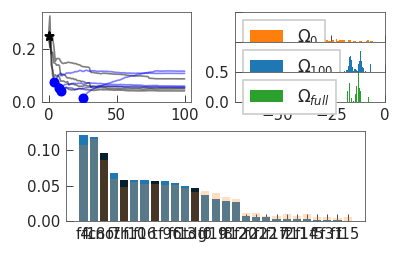

In [174]:
fig = fmt.figure()
subfigures = fig.subfigures(2, 1)

fig_evolution, fig_loglikelihood = subfigures[0].subfigures(1, 2)
fig_evolution = fig_evolution.subplots(1, 1)
fig_gate_usage = subfigures[1].subplots(1, 1)

# Gate evolution plot
for primitive, likelihoods in list(smaller_primitive_likelihood.items()):
    l_array = np.array(likelihoods)
    markerstyle = "o" if str(primitive)[0] == "f" else "*"
    color = "blue" if str(primitive)[0] == "f" else "black"
    fig_evolution.plot(
        l_array[:, 0], l_array[:, 1], label=primitive, alpha=0.5, color=color
    )
    fig_evolution.scatter(*l_array[0], s=25, zorder=10, marker=markerstyle, color=color)
    # plt.annotate(primitive, l_array[0])

# Likelihood plot
ax = fig_loglikelihood.subplots(3, 1)
ax[0].hist(initial_loglikelihoods, 100, density=True, color="C1", label=r"$\Omega_0 $")
ax[1].hist(train_loglikelihoods, 100, density=True, color="C0", label=r"$\Omega_{100}$")
ax[2].hist(full_loglikelihoods, 40, density=True, color="C2", label=r"$\Omega_{full}$")

for a in ax:
    if a != ax[-1]:
        a.set_xticklabels([])
        a.set_yticklabels([])
    a.set_xlim([-70, 0])
    a.set_ylim([0, 0.5])
    a.legend(loc="upper left")
# plt.xlabel("Log likelihood")
# plt.ylabel("Prob")
# plt.subplots_adjust(wspace=0, hspace=0)

# Gate usage histogram
fig_gate_usage.bar(
    np.array(primitive_counts_list)[:, 0],
    np.array(primitive_counts_list)[:, 1].astype(int) / normalized_counts,
    label="frequency",
)

elementary_primitives_counts_list = [
    (name, val) for (name, val) in primitive_counts_list if name[0] != "f"
]
fig_gate_usage.bar(
    np.array(elementary_primitives_counts_list)[:, 0],
    np.array(elementary_primitives_counts_list)[:, 1].astype(int) / normalized_counts,
    color="black",
    alpha=0.75,
)

fig_gate_usage.bar(
    np.array(primitive_probability_list)[:, 0],
    np.array(primitive_probability_list)[:, 1].astype(float),
    alpha=0.25,
    label="weight",
)
# fig_gate_usage.gca().legend()
# fig_gate_usage.gca().set_xticklabels([])
# fig_gate_usage.gca().set_xticks([])


# fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)
fig_loglikelihood.subplots_adjust(wspace=0, hspace=0)
# fig_gate_usage.subplots_adjust(wspace=0, hspace=0)
# fig_evolution.subplots_adjust(wspace=0, hspace=0)
fig.show()

---

### Some tests

Testing enumeration

In [16]:
name_reverse = {v: k for k, v in name.items()}


def replace_back_full_primitives(program):
    program = str(program)
    while True:
        for n in name_reverse:
            program = program.replace(f"{n} ", str(name_reverse[n]) + " ")
        if "f" not in name_reverse:
            break
    return program

In [17]:
for idx, (task, frontier) in enumerate(r.frontiersOverTime.items()):
    if "t_267_" in task.name:
        break

In [22]:
for idx, (task, frontier) in enumerate(r.frontiersOverTime.items()):
    if "t_32941_" in task.name:
        break

true_circuit = get_qiskit_circuit((n_qubit_tasks, task.target_circuit))
print(f"---------------------------------------")
print(f"Task {task.name}")
print("True")
print(true_circuit.circuit)

# code = dc.program.Program.parse("(lambda (lambda (lambda (lambda (f18 (f11 (f6 $0 $3 $2) $3 $1) $1)))))")
code = dc.program.Program.parse(
    replace_back_full_primitives(
        "(lambda (lambda (lambda (lambda (f18 (f11 $3 (f6 $3 $0 $2) $1) $1)))))"
    )
)
arguments = (*range(n_qubit_tasks), (n_qubit_tasks, ()))
circuit = execute_program(code, arguments)
reconstructed_circuit = get_qiskit_circuit(circuit)
print("Reconstructed")
print(reconstructed_circuit.circuit)

task.logLikelihood(code)

replaced_code = dc.program.Program.parse(replace_back_full_primitives(code))

---------------------------------------
Task t_32941_(lambda (lambda (lambda (lambda (y (ch (cs $0 $2 $3) $1 $3) $1)))))
True
               ┌───┐
q_0: ───────■──┤ Y ├
            │  └───┘
q_1: ──■────┼───────
     ┌─┴─┐┌─┴─┐     
q_2: ┤ S ├┤ H ├─────
     └───┘└───┘     
Reconstructed
                              ┌───┐     ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐»
q_0: ────────────■────────────┤ X ├──■──┤ T ├┤ T ├┤ T ├┤ T ├┤ H ├┤ T ├┤ T ├»
     ┌───┐┌───┐  │  ┌───┐     └─┬─┘  │  └───┘└───┘└───┘└───┘└───┘└───┘└───┘»
q_1: ┤ X ├┤ T ├──┼──┤ T ├───────┼────┼─────────────────────────────────────»
     └─┬─┘└───┘┌─┴─┐├───┤┌───┐  │  ┌─┴─┐                                   »
q_2: ──■───────┤ X ├┤ T ├┤ T ├──■──┤ X ├───────────────────────────────────»
               └───┘└───┘└───┘     └───┘                                   »
«     ┌───┐┌───┐┌───┐
«q_0: ┤ T ├┤ T ├┤ H ├
«     └───┘└───┘└───┘
«q_1: ───────────────
«                    
«q_2: ───────────────
«                    


[-17.900579936067537,
 -17.912383463997585,
 -17.93512616605183,
 -17.95053676786994,
 -17.96095614552934,
 -17.974911936916293,
 -17.99793773223593,
 -18.017401064560996,
 -18.046179816408817,
 -18.076672197193986,
 -18.12096307957254,
 -18.133159340452906,
 -18.133159340452906,
 -18.126690299709793,
 -18.126540786090604,
 -18.126540786090604,
 -18.126540786090604,
 -18.12656791858831,
 -18.126585391226296,
 -18.126435908168837,
 -18.126435908168837,
 -18.12645338054844,
 -18.12645338054844,
 -18.12645338054844,
 -18.12645338054844,
 -18.126470852825605,
 -18.126470852825605,
 -18.126470852825605,
 -18.126470852825605,
 -18.126470852825605,
 -18.126470852825605,
 -18.126470852825605,
 -18.126470852825605,
 -18.126470852825605,
 -18.126470852825605,
 -18.126470852825605,
 -18.126470852825605,
 -18.126470852825605,
 -18.126470852825605,
 -18.126470852825605,
 -18.126470852825605,
 -18.126470852825605,
 -18.126470852825605,
 -18.126470852825605,
 -18.126470852825605,
 -18.126470852825605

In [92]:
code = dc.program.Program.parse("(lambda (lambda (lambda (lambda (f11 $0 $3 $1)))))")
arguments = (*range(n_qubit_tasks), (n_qubit_tasks, ()))
circuit = execute_program(code, arguments)
reconstructed_circuit = get_qiskit_circuit(circuit)
print("Reconstructed")
print(reconstructed_circuit.circuit)

task.logLikelihood(code)

replaced_code = dc.program.Program.parse(replace_back_full_primitives(code))
g.logLikelihood(replaced_code.infer(), replaced_code)

Reconstructed
     ┌──────┐
q_0: ┤1     ├
     │      │
q_1: ┤  f11 ├
     │      │
q_2: ┤0     ├
     └──────┘


-6.516377444220209

Testing a specific circuit

Reconstructed
     ┌───┐     
q_0: ┤ X ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘
q_2: ──────────
               


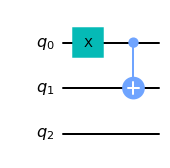

In [44]:
code = dc.program.Program.parse(
    "(lambda (lambda (lambda (lambda (cnot (x $0 $1) $1 $2)))))"
)
# code = dc.program.Program.parse(replace_back_full_primitives("(lambda (lambda (lambda (lambda (f18 (f11 $3 (f6 $3 $0 $2) $1) $1)))))"))
arguments = (*range(n_qubit_tasks), (n_qubit_tasks, ()))
circuit = execute_program(code, arguments)
reconstructed_circuit = get_qiskit_circuit(circuit)
print("Reconstructed")
print(reconstructed_circuit.circuit)
reconstructed_circuit.circuit.draw(
    output="mpl", filename="experimentOutputs/example-cnot.pdf"
)

Reconstructed
     ┌───┐     
q_0: ┤ X ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘


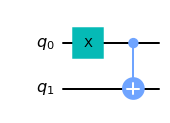

In [45]:
code = dc.program.Program.parse("(lambda (lambda (lambda (cnot (x $0 $1) $1 $2))))")
# code = dc.program.Program.parse(replace_back_full_primitives("(lambda (lambda (lambda (lambda (f18 (f11 $3 (f6 $3 $0 $2) $1) $1)))))"))
arguments = (*range(2), (2, ()))
circuit = execute_program(code, arguments)
reconstructed_circuit = get_qiskit_circuit(circuit)
print("Reconstructed")
print(reconstructed_circuit.circuit)
reconstructed_circuit.circuit.draw(
    output="mpl", filename="experimentOutputs/example-cnot.pdf"
)

Testing enumerated programs

In [ ]:
enumerated_programs = []
with open("logs/tjob_three-long-log-4_3462582_4294967294_err.txt", "r") as f:
    for line in f:
        if "[94mgrammar.py:1991[0m >" in line:
            enumerated_programs.append(line[27:].replace("\n", ""))

In [ ]:
simplified_enumerated_programs = []
for p in tqdm(enumerated_programs):
    s = get_program_simplification(dc.program.Program.parse(p))
    if "f18" in str(s) and "f11" in str(s) and "f6" in str(s):
        print("Candidate:", str(s))
        simplified_enumerated_programs.append(s)


  0%|          | 8474/2927897 [00:05<40:03, 1214.68it/s]

In [ ]:
arguments = (*range(n_qubit_tasks), (n_qubit_tasks, ()))
circuit = execute_program(a, arguments)

Fidelity check

In [ ]:
program = dc.program.Program.parse(
    "(lambda (lambda (lambda (lambda (swap $0 $2 $3)))))"
)
circuit = execute_program(program, arguments)
circuit_to_mat(circuit).round(3)

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

In [ ]:
np.pi * 1j

3.141592653589793j

In [ ]:
mat = circuit_to_mat(circuit)
mat2 = mat * np.exp(np.pi / 4 * 1j)

In [ ]:
np.trace(np.matmul(mat.conj().T, mat)) / len(mat)

0.5

In [ ]:
# mat2 = task.target_circuit_evaluation
np.trace(np.matmul(mat2.conj().T, mat)) / len(mat)

(0.7071067811865476-0.7071067811865475j)

In [ ]:
task.logLikelihood(
    dc.program.Program.parse("(lambda (lambda (lambda (lambda (swap $0 $2 $3)))))")
)

-inf

Plotting example using rsmf

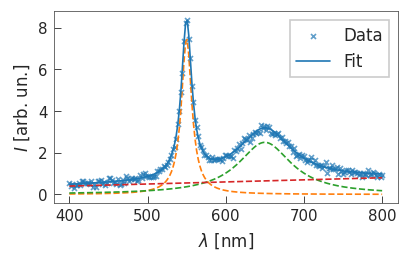

In [ ]:
# Generate dummy spectral data
%matplotlib inline

x = np.linspace(400, 800, 200)
y = (
    30 / (4 + ((x - 550) / 4) ** 2)
    + 30 / (12 + ((x - 650) / 12) ** 2)
    + 0.001 * x
    + np.random.normal(0, 0.1, 200)
)

fig = fmt.figure()

# plot data
data = plt.scatter(x, y, color="C0", alpha=0.7, marker="x")

# plot fits
y_fit1 = 30 / (4 + ((x - 550) / 4) ** 2)
plt.plot(x, y_fit1, color="C1", ls="--")

y_fit2 = 30 / (12 + ((x - 650) / 12) ** 2)
plt.plot(x, y_fit2, color="C2", ls="--")

y_fit3 = 0.001 * x
plt.plot(x, y_fit3, color="C3", ls="--")

y_fit = y_fit1 + y_fit2 + y_fit3
(fit,) = plt.plot(x, y_fit, color="C0")

plt.xlabel("$\\lambda$ [nm]")
plt.ylabel("$I$ [arb. un.]")
plt.legend([data, fit], ["Data", "Fit"])
plt.tight_layout(pad=0.0)

# Save the figure in PDF format
# plt.savefig("example-plotpdf")
plt.show()
